# New York Taxi Fare Prediction Using `Pytorch`

## Reference
- [Dataset Link](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction)

## Outline
- Prepare Notebook
- Load Dataset
- Explore and Preprocess Dataset
- Config GPU
- Linear Model
    - Model Defining
    - Model Training
    - Evaluation
- Testing and Submission
- Hypothesis Testing ( Optional )

Hi 👋, This Notebook I used to practice some `Deep Learning` concepts. I will explain the code one by one. Feel free to use this notebook for yourselves.

*Upvote if you ❤*

## Logs
#### 05-01-2023 Started this notebook and working

### Prepare Notebook

First things First, We have to import some important packages and setup our notebook

In [58]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={"figure.figsize":(10, 8)})

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

import warnings
warnings.filterwarnings('ignore')

### Load Dataset

Next thing we will load our files into pandas first and next we can convert it into `tensors`. First let's check our parent directory and next files by files

In [2]:
PARENT_DIR = '/kaggle/input/new-york-city-taxi-fare-prediction/'

os.listdir(PARENT_DIR)

['sample_submission.csv',
 'GCP-Coupons-Instructions.rtf',
 'train.csv',
 'test.csv']

There are four files in which we only three. `sample_submission.csv`, `train.csv`, `test.csv`. We can use only these files for our notebook. Let's load them into our pandas

In [3]:
# df = pd.read_csv(PARENT_DIR + 'train.csv')

"""
Loading full file will take more ram, because train.csv has 55 Million rows. So we set limit in the rows while loading
"""

df = pd.read_csv(PARENT_DIR + 'train.csv', nrows = 1_000_000)

test_df = pd.read_csv(PARENT_DIR + 'test.csv')

submission_df = pd.read_csv(PARENT_DIR + 'sample_submission.csv')

### Explore and Preprocess Dataset

We finish loading all three files. Let's explore and preprocess these files.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


In [5]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


**Key Insights**
- Maximum `passenger_count` in a taxi 2, But there are maximum count upto 6. Taxi can't ride with six passengers unless it's a bus.
- New york's Coordinates range should above 40 ( Latitude ) and below -73 ( Longitude ) for Pickup and Dropoff. [Refer Here](https://www.latlong.net/place/new-york-city-ny-usa-1848.html_).
- The Minimum `fare_amount` is negative

In [6]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
pd.DataFrame(df['pickup_datetime'].describe())

,pickup_datetime
count,1000000
unique,861755
top,2010-02-13 19:28:00+00:00
freq,9
first,2009-01-01 00:00:46+00:00
last,2015-06-30 23:53:49+00:00


Dataframe contains only values ranging from year `2009` to `2015`. This means, we have only takes values from these because we limit the rows while loading into pandas

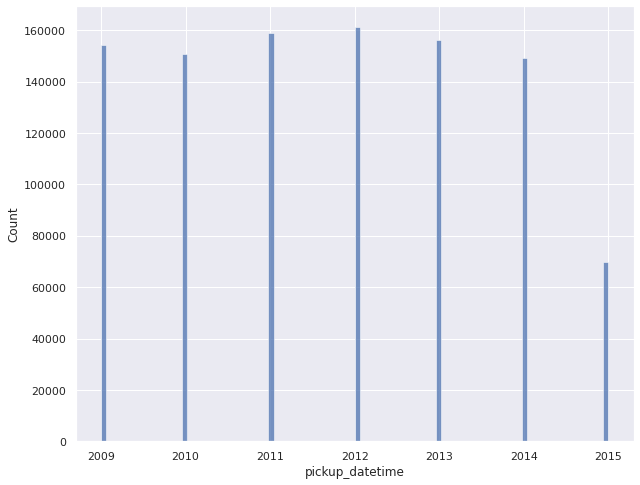

In [7]:
# Question - 1 Which year from 2009 to 2015 has highest taxi rides

sns.histplot(df['pickup_datetime'].dt.year)
plt.show()

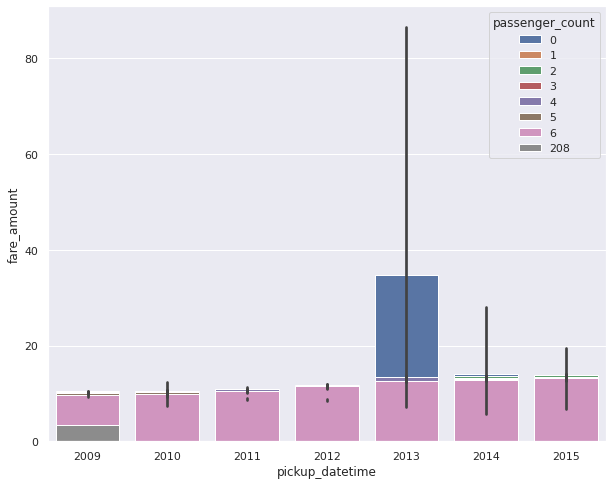

In [8]:
# Question 2 - Which year has more taxi fares ?

sns.barplot(x = df['pickup_datetime'].dt.year, y = df['fare_amount'], hue = df['passenger_count'], dodge = False)
plt.show()

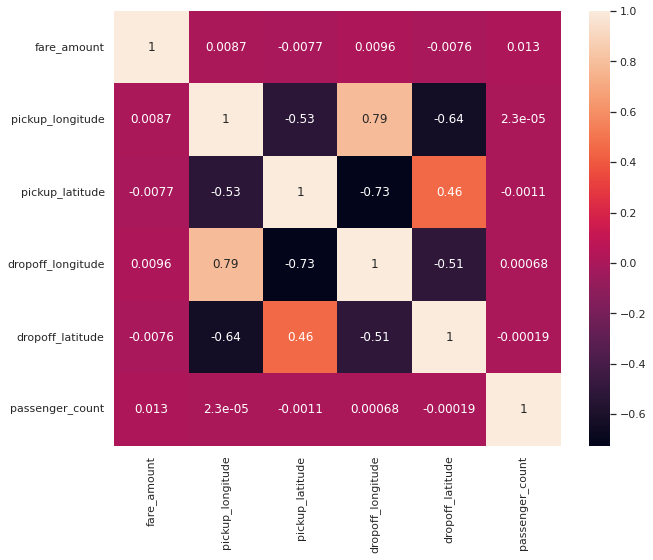

In [9]:
# Question - 3 How did Features correlate with eachother ?

sns.heatmap(df.corr(), annot = True)
plt.show()

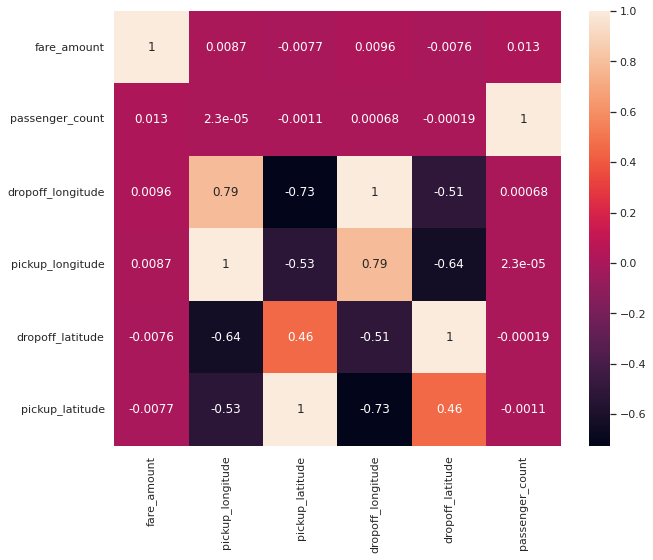

In [10]:
# Question - 4 How did feature correlate with target value ?

sns.heatmap(df.corr().sort_values(by = 'fare_amount', ascending = False), annot = True)
plt.show()

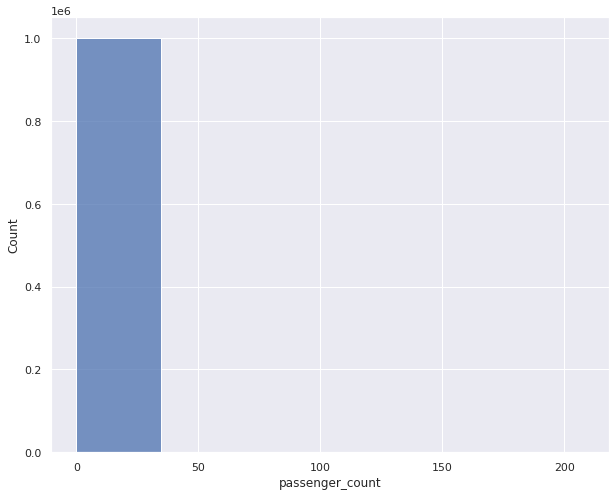

In [11]:
# Question - 5 What is the highest passenger count so far ?

sns.histplot(df['passenger_count'], bins = 6)
plt.show()

We try to answer some of the common questions about the dataset. Let's start preprocessing the dataset for furthur exploration and training.

1. First we split the date into days, week, month, and year
2. Next we remove unwanted columns like `keys`, `pickup_datetime` and we remove out-of-range values in the dataset
3. Next we scale the values, Neural networks even works well without scaling, we try out with scaling first
4. Next to split the dataset for traning and validation

In [80]:
# Class to Split Date
class ChangeDateTime(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        df = X.copy()
        df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
        df['Day'] = df['pickup_datetime'].dt.day
        df['Month'] = df['pickup_datetime'].dt.month
        df['Year'] = df['pickup_datetime'].dt.year
        df['Week'] = df['pickup_datetime'].dt.week
        df['Weekday'] = df['pickup_datetime'].dt.weekday
        return df

In [81]:
# Class to Remove Unwanted Columns and values

class RemoveUnvalid(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self
    
    def selectWithInBoundaries(self, df):
        BB = (-74.5, -72.8, 40.5, 41.8)
        return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
    
    def transform(self, X):
        df = X.copy()
        df = df.drop(['key', 'pickup_datetime'], axis = 1)
        
        df = df[self.selectWithInBoundaries(df)]
        return df

In [14]:
# Class for Scaling Numerical Values

class Scaling(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        df = X.copy()
        scaler = MinMaxScaler()
        df = scaler.fit_transform(df)
        return df

In [82]:
# Class to Split Dataset into validation and training

class SplitDataset(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        df = pd.DataFrame(X)
        label = df[[0]]
        features = df.drop(0, axis = 1)
        return (features, label)


In [83]:
mainPipeline = Pipeline([
    ('changing', ChangeDateTime()),
    ('removeUnvalid', RemoveUnvalid()),
    ('scaling', Scaling()),
    ('splitDataset', SplitDataset())
])

Now we created our Pipeline and it's time to load it and fit it.

In [84]:
inputs, outputs = mainPipeline.fit_transform(df)
# inputShape, outputShape = inputs.shape, outputs.shape

inputs.values.shape, outputs.values.shape

((979052, 10), (979052, 1))

After fitting it into Pipeline, it's time to load it into pytorch and convert it into `tensor`.

In [26]:
dataset = TensorDataset(torch.tensor(inputs.to_numpy(), dtype = torch.float32), torch.tensor(outputs.to_numpy(), dtype = torch.float32))

We are going to use only `2 %` of the dataset for validation and a batch size of `128`

In [27]:
valSize = int(0.2 * len(dataset))
trainSize = int(len(dataset) - valSize)

batchSize = 128

trainDs, valDs = random_split(dataset, [trainSize, valSize])

trainLoader = DataLoader(trainDs, batchSize, shuffle = True)
valLoader = DataLoader(valDs, batchSize, shuffle = True)

In [28]:
len(trainLoader.dataset), len(valLoader)

(783242, 1530)

### Config GPU

We processed the dataset and converted it into `tensors`. Now it's time to configure the `GPU` and `Model`. Let's first Config the gpu

In [21]:
# Function to get default device

def getDevice():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

# Function to transfer data to device

def toDevice(data, device):
    if isinstance(data, (list, tuple)):
        return [toDevice(x, device) for x in data]
    return data.to(device, non_blocking = True)

# Class for converting dataloader

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for batch in self.dl:
            yield toDevice(batch, self.device)
    
    def __len__(self):
        return len(self.dl)

Now it's time to get the device and load it into `DataLoader`

In [40]:
device = getDevice()

trainLoader = DeviceDataLoader(trainLoader, device)
valLoader = DeviceDataLoader(valLoader, device)

### Linear Model - Defining

Now that we configed `GPU`. we start creating our models, Our model is linear model

In [47]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(in_features = 10, out_features = 50),
            nn.ReLU(),
            nn.Linear(in_features = 50, out_features = 100),
            nn.LeakyReLU(),
            nn.Linear(in_features = 100, out_features = 1)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [48]:
linearModel = LinearModel().to(device)
linearModel

LinearModel(
  (network): Sequential(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=100, out_features=1, bias=True)
  )
)

### Linear Model - Training

It's time for training the model and creating submissions.

In [50]:
# Storage for our results

results = {
    'trainLoss' : [],
    'trainAcc' : [],
    'valLoss': [],
    'valAcc': []
}

In [52]:
def trainStep(model, dataLoader, lossFu, optimizer):
    """Function to Train the Model"""
    model.train()
    trainLoss, trainAcc = 0, 0
    for batch, (X, y) in enumerate(dataLoader):
        yPred = model(X)
        loss = lossFu(yPred, y)
        trainLoss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        yPredClass = torch.argmax(torch.softmax(yPred, dim = 1), dim = 1)
        trainAcc += (yPredClass == y).sum().item() / len(yPred)
        trainLoss = trainLoss / len(dataLoader)
        trainAcc = trainAcc / len(dataLoader)
        return trainLoss, trainAcc

In [53]:
def valStep(model, dataLoader, lossFu):
    """Function for Validating model"""
    model.eval() 
    valLoss, valAcc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataLoader):
            testPredLogits = model(X)
            loss = lossFu(testPredLogits, y)
            valLoss += loss.item()
            testPredLabels = testPredLogits.argmax(dim=1)
            valAcc += ((testPredLabels == y).sum().item()/len(testPredLabels))
    valLoss = valLoss / len(dataLoader)
    valAcc = valAcc / len(dataLoader)
    return valLoss, valAcc

In [57]:
epochs = 5
lossFu = nn.MSELoss()
optimizer = torch.optim.SGD(linearModel.parameters(), lr=0.01)

In [59]:
def train(model, trainLoader, valLoader, optimizer, lossFu, epochs = 5):
    """Function for Train and Val Loop"""
    for epoch in range(epochs):
        trainLoss, trainAcc = trainStep(model, trainLoader, lossFu, optimizer)
        valLoss, valAcc = valStep(model, valLoader, lossFu)
        print(
            f"Epoch: {epoch+1} | "
            f"Training Loss: {trainLoss:.4f} | "
            f"Training Accuracy: {trainAcc:.4f} | "
            f"Validating Loss: {valLoss:.4f} | "
            f"Validating Accuracy: {valAcc:.4f}"
        )
        results["trainLoss"].append(trainLoss)
        results["trainAcc"].append(trainAcc)
        results["valLoss"].append(valLoss)
        results["valAcc"].append(valAcc)

In [60]:
train(linearModel, trainLoader, valLoader, optimizer, lossFu, 5)

Epoch: 1 | Training Loss: 0.0000 | Training Accuracy: 0.0000 | Validating Loss: 0.0226 | Validating Accuracy: 0.0000
Epoch: 2 | Training Loss: 0.0000 | Training Accuracy: 0.0000 | Validating Loss: 0.0205 | Validating Accuracy: 0.0000
Epoch: 3 | Training Loss: 0.0000 | Training Accuracy: 0.0000 | Validating Loss: 0.0186 | Validating Accuracy: 0.0000
Epoch: 4 | Training Loss: 0.0000 | Training Accuracy: 0.0000 | Validating Loss: 0.0169 | Validating Accuracy: 0.0000
Epoch: 5 | Training Loss: 0.0000 | Training Accuracy: 0.0000 | Validating Loss: 0.0154 | Validating Accuracy: 0.0000


In [61]:
train(linearModel, trainLoader, valLoader, optimizer, lossFu, 10)

Epoch: 1 | Training Loss: 0.0000 | Training Accuracy: 0.0000 | Validating Loss: 0.0140 | Validating Accuracy: 0.0000
Epoch: 2 | Training Loss: 0.0000 | Training Accuracy: 0.0000 | Validating Loss: 0.0128 | Validating Accuracy: 0.0000
Epoch: 3 | Training Loss: 0.0000 | Training Accuracy: 0.0000 | Validating Loss: 0.0116 | Validating Accuracy: 0.0000
Epoch: 4 | Training Loss: 0.0000 | Training Accuracy: 0.0000 | Validating Loss: 0.0106 | Validating Accuracy: 0.0000
Epoch: 5 | Training Loss: 0.0000 | Training Accuracy: 0.0000 | Validating Loss: 0.0096 | Validating Accuracy: 0.0000
Epoch: 6 | Training Loss: 0.0000 | Training Accuracy: 0.0000 | Validating Loss: 0.0088 | Validating Accuracy: 0.0000
Epoch: 7 | Training Loss: 0.0000 | Training Accuracy: 0.0000 | Validating Loss: 0.0080 | Validating Accuracy: 0.0000
Epoch: 8 | Training Loss: 0.0000 | Training Accuracy: 0.0000 | Validating Loss: 0.0073 | Validating Accuracy: 0.0000
Epoch: 9 | Training Loss: 0.0000 | Training Accuracy: 0.0000 | V

In [66]:
def showResults(results, accuracy = True):
    if accuracy:
        plt.plot(results['trainAcc'])
        plt.plot(results['valAcc'])
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.grid()
        plt.legend(['Traning', 'Validation'])
        plt.show()
    else:
        plt.plot(results['trainLoss'])
        plt.plot(results['valLoss'])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.grid()
        plt.legend(['Traning', 'Validation'])
        plt.show()

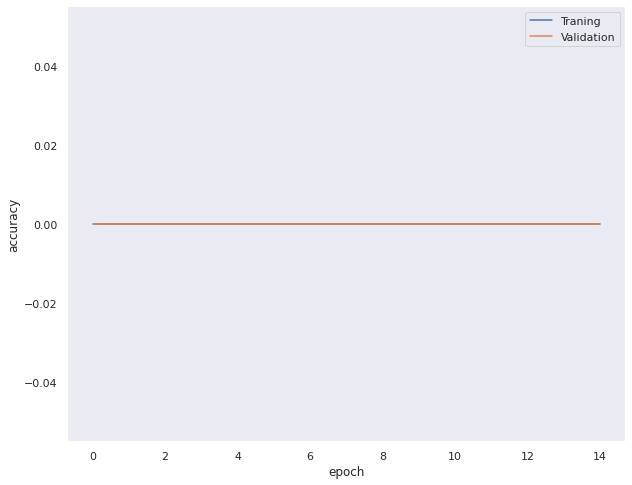

In [67]:
showResults(results, accuracy = True)

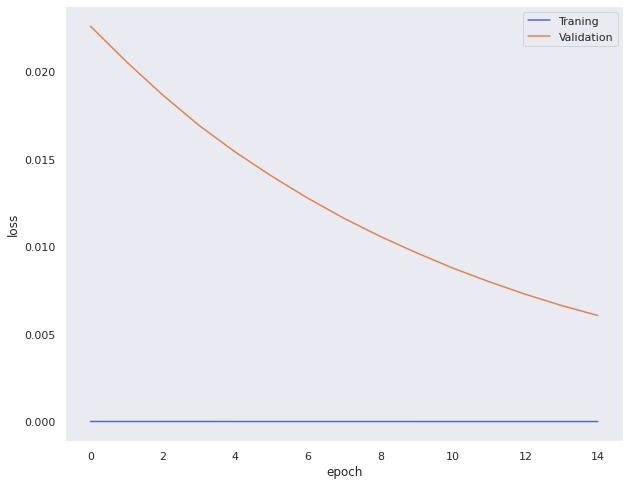

In [68]:
showResults(results, accuracy = False)

### Linear Model - Testing